# Results.ipynb

### This notebook analyses the data for the Results section of the thesis.

Author: Erik Puijk <br>
Date  : May 9, 2022

In [1]:
import json
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
plt.close("all")

In [2]:
def read_json(path):
    """ Read the Tweets from a given text file and return in JSON-format. """
    
    content = ""
    
    try:
        with open(path, 'r') as f:
            content = json.loads(f.read())
    except IOError:
        print("I/O error")
        
    #print("Total Tweets read: %s\n" % (len(content)))

    return content

In [3]:
def write_csv(headers, rows, path):
    """ Write results from the analysis to a csv-file in a specified path. """
    
    with open(path, 'w') as f:
        w = csv.writer(f, lineterminator='\n')
        
        w.writerow(headers)
        w.writerows(rows)
    
    #print("Total rows written: %s\n" % (len(rows) + 1))

In [4]:
def fix_date(date):
    """ Takes a date in the format yyyy-mm-dd and returns date in format dd-mm. """

    return str(date)[5:10][3:] + '-' + str(date)[5:10][:2]

In [5]:
def avg_engagement_per_category(tweets):
    """ Count the occurrences and average engagement of each category. """
    
    cat_con = [['cat_con', x, sum(tweets.cat_con == x), 
                "%.10f%%" % round(sum(tweets.cat_con == x) / len(tweets) * 100, 10),
                "%.2f" % round(tweets.loc[tweets['cat_con'] == x, 'total_engagement'].mean() * 1000, 2)]
               for x in sorted(tweets.cat_con.unique())]
    cat_act = [['cat_act', x, sum(tweets.cat_act == x), 
                "%.10f%%" % round(sum(tweets.cat_act == x) / len(tweets) * 100, 10),
                "%.2f" % round(tweets.loc[tweets['cat_act'] == x, 'total_engagement'].mean() * 1000, 2)]
               for x in sorted(tweets.cat_act.unique())]
    media_type = [['media_type', x, sum(tweets.media_type == x), 
                   "%.10f%%" % round(sum(tweets.media_type == x) / len(tweets) * 100, 10), 
                   "%.2f" % round(tweets.loc[tweets['media_type'] == x, 'total_engagement'].mean() * 1000, 2)]
               for x in sorted(tweets.media_type.unique())]
    
    # Write results to a csv file
    write_csv(['Type', 'Category', 'N', 'Percentage', 'Average engagement (x1000)'],
             [*cat_con, *cat_act, *media_type],
             'results/avg_engagement_per_category.csv')

In [6]:
# def avg_engagement_per_party(tweets, users):
    
#     df = tweets[['author_handle', 'cat_con', 'cat_act', 'media_type', 'total_engagement']].copy()
#     df.insert(0, 'party', "")
    
#     for index, row in users.iterrows():
#         df.loc[df.author_handle == row['handle'], 'party'] = row['party']
    
#     parties = users.party.unique()
#     data = []
    
#     # TO FINISH!
#     for party in parties:
#         n = len(df[(df['party'] == party)])
#         data.append([party, 
#                      "%.2f" % round(df.loc[df['party'] == party, 'total_engagement'].mean() * 1000, 2),
#                      "CAM: %.1f%%" % round(len(df[(df['party'] == party) & (df['cat_con'] == 'CAM')]) / n * 100, 1)])
#     print(data)
#     # Write results to a csv file
#     write_csv(['Party', 'Average engagement (x1000)', 'Content type', 'Activation type', 'Media type'], 
#               data,
#              'results/avg_engagement_per_party.csv')

In [7]:
def plot_overall(x, y1, y2, interval, auth_label):
    """ Plot the number of Tweets (bar) and the average engagement (line) per time interval in a single figure. """
    
    # Reformat date
    x = [fix_date(date) for date in x]
    
    fig, ax1 = plt.subplots(figsize = (6, 4))
    ax1.bar(x, y1, width = 0.5, label='Number of Tweets')
    ax2 = ax1.twinx()
    
    # Multiply engagement by 1000
    y2 = [number*1000 for number in y2]
    ax2.plot(x, y2, '-r')
    ax1.plot(np.nan, '-r', label = 'Average engagement')
    
    ax1.legend(loc=2)
    
    if interval == 'day':
        plt.xticks(np.arange(0, len(x), 7.0))
    
    # Set labels and title
    ax1.set_xlabel(interval.capitalize())
    ax1.set_ylabel('Number of Tweets')
    ax2.set_ylabel('Average engagement (x1000)')
    ax2.set_ylim(ymin=0, ymax=max(y2)*1.3)
    plt.title('Number of Tweets and average engagement')
    
    plt.savefig('results/overall_%s_%s.png' % (interval, auth_label))
    plt.show()

In [8]:
def plot_categories(ylabel, title, x, y, labels, interval, filename, ymax):
    """ Plot the occurrence of messaging strategies relative to the total number of Tweets posted in the time
    interval. """

    fig, ax = plt.subplots(figsize = (6, 4))
    
    # Reformat dates and multiply ratio's to get percentages
    x = [fix_date(date) for date in x]
    y = [[j*100 for j in y[i]] for i in range(len(y))]
    
    # Multiply ratios in y by 100 to get a percentage
    if len(labels) == 0:
        ax.plot(x, y)
    else:
        for i, label in enumerate(labels):
            ax.plot(x,[lst[i] for lst in y], label=label)
    
    if interval == 'day':
        plt.xticks(np.arange(0, len(x), 7.0))
    
    # Set labels and title
    ax.set_xlabel(interval.capitalize())
    ax.set_ylabel(ylabel)
    ax.set_ylim(ymin=0, ymax=ymax)
    plt.title(title)
    
    # Only generate legend if more than one labels
    if len(labels) > 0:
        ax.legend()
    
    plt.savefig('results/%s.png' % filename)
    plt.show()

In [13]:
def engagement_per_interval(tweets, all_users, interval, file_label, authors):
    """ Plot the number of Tweets, average engagement and use of content, activation and media type strategies
        per day or per week for the given authors. """  
    
    # Generate list of all authors if given author list is empty
    if len(authors) == 0:
        authors = all_users['handle'].tolist()
    
    # Copy selection of data frame
    df = tweets[tweets['author_handle'].isin(authors)]
    df = df[['created_at', 'author_handle', 'cat_con', 'cat_act', 'media_type', 'total_engagement']].copy()
    
    # Insert temporary column with creation date (without time)
    df.insert(0, 'temp', pd.to_datetime(df.created_at.str[:10], format='%Y-%m-%d'))
    
    # Creation date with time can be removed
    del df['created_at']
    
    # List and sort all days
    dates = pd.date_range(pd.to_datetime('2021-02-04', format='%Y-%m-%d'), periods=42).tolist()
    
    if interval == 'week':
        # If interval is week, only keep week starting dates (Thursdays)
        dates = [date for i, date in enumerate(dates) if i % 7 == 0]  
    
    df.insert(0, 'date', "")
    
    # Insert week start date as column
    for i, date in enumerate(dates):

        if interval == 'week':
            # Compare if date is equal to or larger than the checked start date, use that start date
            df.loc[df.temp >= dates[i], 'date'] = date.date()
        else:
            df.loc[df.temp == dates[i], 'date'] = date.date()

    # Delete temporary column
    del df['temp']
                
    num_tweets = []
    avg_engagement = []
    cat_con = []
    cat_act = []
    media_type = []
    
    # Create copy of original dates without time
    dates2 = [date.date() for date in dates]
    
    print(df['total_engagement'].mean() * 1000)
    print(len(df))
        
    for i, date in enumerate(dates2):
        # Make lists that will be plotted on y-axes
        num_tweets.append(len(df[(df['date'] == date)]))
        avg_engagement.append(df[(df['date'] == date)]['total_engagement'].mean())
        cat_con.append([len(df[(df['date'] == date) & (df['cat_con'] == 'CAM')]) / num_tweets[i],
                       len(df[(df['date'] == date) & (df['cat_con'] == 'POL')]) / num_tweets[i],
                       len(df[(df['date'] == date) & (df['cat_con'] == 'SOC')]) / num_tweets[i]])
        cat_act.append([len(df[(df['date'] == date) & (df['cat_act'] == 'CON')]) / num_tweets[i],
                       len(df[(df['date'] == date) & (df['cat_act'] == 'FOL')]) / num_tweets[i],
                       len(df[(df['date'] == date) & (df['cat_act'] == 'NONE')]) / num_tweets[i],
                       len(df[(df['date'] == date) & (df['cat_act'] == 'SUP')]) / num_tweets[i]])
        media_type.append([len(df[(df['date'] == date) & (df['media_type'] == 'animated_gif')]) / num_tweets[i],
                       len(df[(df['date'] == date) & (df['media_type'] == 'none')]) / num_tweets[i],
                       len(df[(df['date'] == date) & (df['media_type'] == 'photo')]) / num_tweets[i],
                       len(df[(df['date'] == date) & (df['media_type'] == 'video')]) / num_tweets[i]])
    
    # Plot the lists
    plot_overall(dates2, num_tweets, avg_engagement, interval, file_label)
    plot_categories('Percentage of Tweets', 'Use of content type strategies', dates2, cat_con, 
               ['CAM', 'POL', 'SOC'], interval, 'cat_con_' + interval + '_' + file_label, 100)
    plot_categories('Percentage of Tweets', 'Use of activation type strategies', dates2, cat_act, 
               ['CON', 'FOL', 'NONE', 'SUP'], interval, 'cat_act_' + interval + '_' + file_label, 100)
    plot_categories('Percentage of Tweets', 'Use of media type strategies', dates2, media_type, 
               ['animated_gif', 'none', 'photo', 'video'], interval, 'media_type_' + interval + '_' + file_label, 
                    80)

8.662568069040411
1308


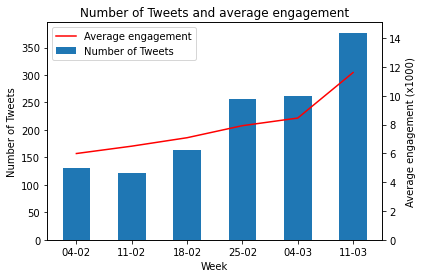

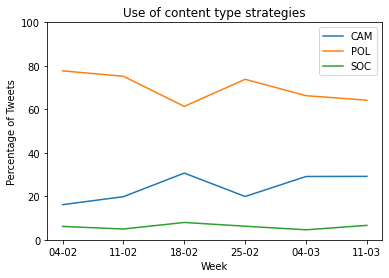

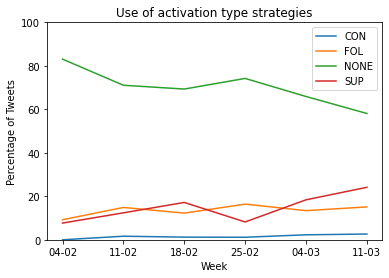

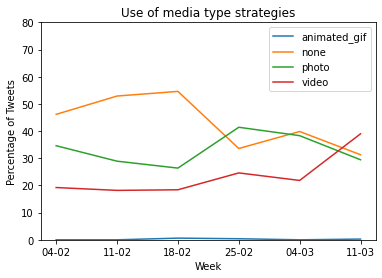

In [15]:
tweets = read_json('source/tweets_all_labeled.txt')
tweets_pd = pd.DataFrame(tweets)
users_pd = pd.read_csv('source/users.csv')

# Show the number of Tweets and average engagement per messaging strategy
avg_engagement_per_category(tweets_pd)

# Run for all parties
#engagement_per_interval(tweets_pd, users_pd, 'week', 'all', [])

# # Run for winning parties
engagement_per_interval(tweets_pd, users_pd, 'week', 'winners', ['VoltNederland', 'DassenLaurens',
                                                       'D66', 'SigridKaag',
                                                       'fvdemocratie', 'thierrybaudet'])

# # Run for losing parties
# engagement_per_interval(tweets_pd, users_pd, 'week', 'losers', ['cdavandaag', 'WBHoekstra',
#                                                       'SPnl', 'MarijnissenL',
#                                                       'groenlinks', 'jesseklaver'])

# Run for parties
#engagement_per_interval(tweets_pd, users_pd, 'week', 'parties', 
#                        users_pd.loc[users_pd['type'] == 'party', 'handle'].tolist())

# Run for party leaders
#engagement_per_interval(tweets_pd, users_pd, 'week', 'leaders', 
#                        users_pd.loc[users_pd['type'] == 'person', 'handle'].tolist())


# Run for largest parties
# engagement_per_interval(tweets_pd, users_pd, 'week', 'largest', ['VVD', 'markrutte',
#                                                                  'D66', 'SigridKaag',
#                                                                  'geertwilderspvv'])

# Run for smallest parties
# engagement_per_interval(tweets_pd, users_pd, 'week', 'smallest', ['PolitiekBIJ1', 'SylvanaBIJ1',
#                                                                   'BoerBurgerB', 'lientje1967',
#                                                                   '50pluspartij', 'LianedenHaan'])

# # engagement_per_interval(tweets_pd, 'week', ['VVD', 'markrutte'])
# # engagement_per_interval(tweets_pd, 'week', ['D66', 'SigridKaag'])
# # engagement_per_interval(tweets_pd, 'week', ['geertwilderspvv'])
# engagement_per_interval(tweets_pd, 'week', ['cdavandaag', 'WBHoekstra'])
# # engagement_per_interval(tweets_pd, 'week', ['SPnl', 'MarijnissenL'])
# engagement_per_interval(tweets_pd, 'week', ['PvdA', 'PloumenLilianne'])
#engagement_per_interval(tweets_pd, 'week', ['groenlinks', 'jesseklaver'])
#engagement_per_interval(tweets_pd, 'week', ['fvdemocratie', 'thierrybaudet'])
# engagement_per_interval(tweets_pd, 'week', ['PartijvdDieren', 'estherouwehand'])
# # engagement_per_interval(tweets_pd, 'week', ['christenunie', 'gertjansegers'])
# engagement_per_interval(tweets_pd, 'week', ['VoltNederland', 'DassenLaurens'])
# # engagement_per_interval(tweets_pd, 'week', ['JuisteAntwoord', 'Eerdmans'])
# # engagement_per_interval(tweets_pd, 'week', ['SGPnieuws', 'keesvdstaaij'])
# engagement_per_interval(tweets_pd, 'week', ['DenkNL', 'F_azarkan'])
# # engagement_per_interval(tweets_pd, 'week', ['50pluspartij', 'LianedenHaan'])
# # engagement_per_interval(tweets_pd, 'week', ['BoerBurgerB', 'lientje1967'])
# # engagement_per_interval(tweets_pd, 'week', ['PolitiekBIJ1', 'SylvanaBIJ1'])